In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["CHROMA_TELEMETRY_ENABLED"] = "false"

In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Gemma2-9b-It")

In [6]:
llm.invoke("hello there").content

'General Kenobi! 👋\n\nWhat can I do for you today?\n'

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [8]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_post",
    "Search and return information about Lilian Weng blog post on LLM agents, prompt engineering, and adversila attacts on LLms."
)

tools = [retriever_tool]

####  Retriver grader.

In [37]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description = "Documents are relevant to the question, 'yes' or 'no'"
    )

#llm with funcion call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [38]:
# Prompt
system = """You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  
If the document has words or meanings related to the question, mark it as relevant.  
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [39]:
retrival_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)

In [40]:
docs

[Document(metadata={'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in

In [41]:
doc_txt = docs[1].page_content

In [ ]:
print(retrival_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [43]:
question = "Who is Cristiano Ronaldo ?"
print(retrival_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


### Data Generation.

In [44]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")


In [45]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [46]:
docs

[Document(metadata={'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in

In [47]:
rag_chain = prompt | llm

In [48]:
question = "what is an AI Agent?"

In [49]:
generation = rag_chain.invoke({"context": docs, "question": question})

In [50]:
generation.content

'An AI agent is a computer program that can perform tasks autonomously.  \n\nIt uses a large language model (LLM) as its "brain" and is enhanced by components like memory, planning, and tool use to accomplish goals. \nAutoGPT, GPT-Engineer, and BabyAGI are examples of AI agents.  \n'

### Hallucination Grader

In [51]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [52]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [53]:
# Prompt
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.  
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [54]:
hallucinations_grader = hallucination_prompt | structured_llm_grader

In [55]:
print(hallucinations_grader.invoke({"documents": docs, "generation": generation}))

binary_score='yes'


### Answer Grader

In [56]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
print(answer_grader.invoke({"question": question, "generation": generation}))

binary_score='yes'


### Question Re-writer

In [58]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.  
You are given both a question and a document.  
- First, check if the question is relevant to the document by identifying a connection or relevance between them.  
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.  
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase 
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'."""
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [59]:
question = "who is a current indian Presudent of Kenya?"

In [61]:
question_rewriter.invoke({"question":question,"documents":docs})

'question not relevant \n'

In [64]:
from typing import List
from typing_extensions import TypedDict
class AgentState(TypedDict):
    question: str
    generation: str
    documents: List[str]
    filter_documents: List[str]
    unfilter_documents: List[str]

In [65]:
def retrieve(state:AgentState):
    print("----RETRIEVE----")
    question = state['question']
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [66]:
def grade_documents(state:AgentState):
    print("----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']
    
    filtered_docs = []
    unfiltered_docs = []
    for doc in documents:
        score = retrival_grader.invoke({"question":question, "document":doc})
        grade = score.binary_score
        
        if grade=='yes':
            print("----GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(doc)
        else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            unfiltered_docs.append(doc)
    if len(unfiltered_docs) > 1:
        return {"unfilter_documents": unfiltered_docs,"filter_documents":[], "question": question}
    else:
        return {"filter_documents": filtered_docs,"unfilter_documents":[],"question": question}
            
            

In [67]:
def decide_to_generate(state:AgentState):
    print("----ACCESS GRADED DOCUMENTS----")
    state["question"]
    unfiltered_documents = state["unfilter_documents"]
    filtered_documents = state["filter_documents"]
    
    
    if unfiltered_documents:
        print("----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----")
        return "transform_query"
    if filtered_documents:
        print("----DECISION: GENERATE----")
        return "generate"

In [68]:
def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]
    
    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}

In [70]:
from langgraph.graph import END, StateGraph, START
def transform_query(state:AgentState):
    question=state["question"]
    documents=state["documents"]
    
    print(f"this is my document{documents}")
    response = question_rewriter.invoke({"question":question,"documents":documents})
    print(f"----RESPONSE---- {response}")
    if response == 'question not relevant':
        print("----QUESTION IS NOT AT ALL RELEVANT----")
        return {"documents":documents,"question":response,"generation":"question was not at all relevant"}
    else:   
        return {"documents":documents,"question":response}

In [71]:
def decide_to_generate_after_transformation(state:AgentState):
    question=state["question"]
    
    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [72]:
import pprint
def grade_generation_vs_documents_and_question(state:AgentState):
    print("---CHECK HELLUCINATIONS---")
    question= state['question']
    documents = state['documents']
    generation = state["generation"]
    
    score = hallucinations_grader.invoke({"documents":documents,"generation":generation})
    
    grade = score.binary_score
    
    #Check hallucinations
    if grade=='yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        
        print("---GRADE GENERATION vs QUESTION ---")
        
        score = answer_grader.invoke({"question":question,"generation":generation})
        
        grade = score.binary_score
        
        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"

### From here Workflow will start

In [73]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents) 
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)

In [74]:
workflow.add_edge(START,"Docs_Vector_Retrieve")
workflow.add_edge("Docs_Vector_Retrieve","Grading_Generated_Documents")
workflow.add_conditional_edges("Grading_Generated_Documents",
                            decide_to_generate,
                            {
                            "generate": "Content_Generator",
                            "transform_query": "Transform_User_Query"
                            }
                            )
workflow.add_conditional_edges("Content_Generator",
                            grade_generation_vs_documents_and_question,
                            {
                            "useful": END,
                            "not useful": "Transform_User_Query",
                            }
                            )

workflow.add_conditional_edges("Transform_User_Query",
                decide_to_generate_after_transformation,
                {
                "Retriever":"Docs_Vector_Retrieve",
                "query_not_at_all_relevant":END
                }
                )

In [75]:
app = workflow.compile()

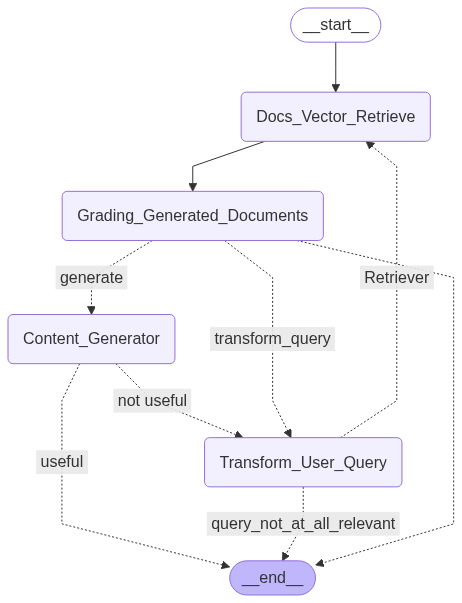

In [76]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [77]:
inputs = {"question": "Explain how the different types of agent memory work?"}

In [78]:
app.invoke(inputs)['generation']

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content='LLM-powered autonomous agents use short-term memory for in-context learning and long-term memory to store and recall information over extended periods. \n\nLong-term memory often utilizes an external vector store for fast retrieval of information. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 2141, 'total_tokens': 2193, 'completion_time': 0.094545455, 'prompt_time': 0.071098379, 'queue_time': 0.242509476, 'total_time': 0.165643834}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--1a49821e-f616-49a5-9bba-042e4548dfd3-0', usage_metadata={'input_tokens': 2141, 'output_tokens': 52, 'total_tokens': 2193})

In [79]:
inputs = {"question": "who is a prompt engineering?"}

In [80]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content="Prompt engineering is the practice of designing effective prompts to guide the behavior of large language models (LLMs).  It involves finding ways to communicate with LLMs to elicit desired responses without altering the model's underlying weights.  This is an empirical field requiring experimentation and refinement to achieve optimal results. \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 1108, 'total_tokens': 1171, 'completion_time': 0.114545455, 'prompt_time': 0.037272728, 'queue_time': 0.265938755, 'total_time': 0.151818183}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--57820a31-075e-4931-a74f-72a6a1f80deb-0', usage_metadata={'input_tokens': 1108, 'output_tokens': 63, 'total_tokens': 1171})

In [81]:
inputs = {"question": "what is role of data structure while creating ai agentic pattern?"}

In [82]:
app.invoke(inputs)

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----
this is my document[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'language': 'en', 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent break

{'question': 'How does the use of a vector store and fast retrieval contribute to the long-term memory of an LLM-powered autonomous agent? \n\n\n',
 'generation': AIMessage(content='An external vector store allows the agent to store a vast amount of information, and fast retrieval enables the agent to quickly access this information when needed. This combination provides the long-term memory necessary for the agent to learn from past experiences and make informed decisions. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 2078, 'total_tokens': 2133, 'completion_time': 0.1, 'prompt_time': 0.068505916, 'queue_time': 0.24270598799999998, 'total_time': 0.168505916}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--b3bb4dd3-c262-4051-abc3-5a0994332155-0', usage_metadata={'input_tokens': 2078, 'output_tokens': 55, 'total_tokens': 2133}),
 'documents': [Document(meta

In [83]:
inputs = {"question": "what is role of c language and php while creating ai agentic pattern?"}

In [84]:
app.invoke(inputs)

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----
this is my document[Document(metadata={'title': "LLM Powered Autonomous Agents | Lil'Log", 'language': 'en', 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down

TypeError: 'module' object is not callable. Did you mean: 'pprint.pprint(...)'?

In [86]:
inputs = {"question": "who is a first president of USA?"}
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----
this is my document[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text gen

AIMessage(content='Several effective strategies for prompting language models in closed-book scenarios include providing explicit context within the prompt, using chain-of-thought prompting to guide reasoning, and incorporating retrieved knowledge from external sources.  Experimentation and careful selection of prompt engineering methods are crucial for optimal performance as their effectiveness can vary across different models.  \n\n\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 1138, 'total_tokens': 1206, 'completion_time': 0.123636364, 'prompt_time': 0.038477413, 'queue_time': 0.24106621899999997, 'total_time': 0.162113777}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--a1126727-6a9a-48e6-b490-465e26b00672-0', usage_metadata={'input_tokens': 1138, 'output_tokens': 68, 'total_tokens': 1206})